# 'Number of' Cluster in Layer 12 (4740)

Model: Gemma-2-2b
Layer: 12
Activation Threshold: 1.5
Batch Size for graph generation: 100
Number of PCA examples searched for: 5000


In [3]:
%load_ext autoreload
%autoreload 2
import os
from dataclasses import dataclass
from os.path import join as pj

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch

from sae_cooccurrence.normalised_cooc_functions import (
    neat_sae_id,
)
from sae_cooccurrence.pca import (
    plot_token_pca_and_save,
)
from sae_cooccurrence.streamlit import (
    generate_color_palette,
    load_streamlit_config,
    load_subgraph_data,
    plot_pca_2d,
)
from sae_cooccurrence.utils.saving_loading import load_npz_files
from sae_cooccurrence.utils.set_paths import get_git_root

Setup

In [4]:
git_root = get_git_root()

In [5]:
config = load_streamlit_config(
    pj(git_root, "src", "config_pca_streamlit_maxexamples.toml")
)

Options

In [6]:
save_figs = False

Setup

In [7]:
model_name = "gemma-2-2b"
sae_release_short = "gemma-scope-2b-pt-res-canonical"
sae_id = "layer_12/width_16k/canonical"
layer = 12
fs_splitting_cluster = 4740

activation_threshold = 1.5

# As I am using the streamlit loading function, I need to specify the graph size and the number of batches for reconstruction
graph_size = 4
n_batches_reconstruction = 100
batch_size = 100
pca_cap = 5000
pca_prefix = "pca"

Convert to neat format

In [8]:
subgraph_id = fs_splitting_cluster
activation_threshold_safe = str(activation_threshold).replace(".", "_")
sae_id_neat = neat_sae_id(sae_id)

Paths

In [9]:
results_dir = f"results/{model_name}/{sae_release_short}/{sae_id_neat}"
results_path = pj(git_root, results_dir)

In [10]:
pre_computed_pca_path = pj(
    get_git_root(),
    results_dir,
    f"layer_{layer}_width_16k_canonical_pca_for_streamlit",
    f"{pca_cap}cap_graph_analysis_results_size_{graph_size}_nbatch_{n_batches_reconstruction}.h5",
)

In [11]:
node_df = pd.read_csv(
    pj(results_path, f"dataframes/node_info_df_{activation_threshold_safe}.csv")
)

overall_feature_activations = load_npz_files(
    results_path, "feature_acts_cooc_activations"
).get(activation_threshold)

fs_splitting_nodes = node_df.query("subgraph_id == @subgraph_id")["node_id"].tolist()

Loading npz files:   0%|          | 0/1 [00:00<?, ?it/s]

Paths for saving out

In [12]:
figures_path = pj(git_root, f"figures/{model_name}/{sae_release_short}/{sae_id_neat}")
pca_dir = f"{pca_prefix}_{activation_threshold_safe}_subgraph_{subgraph_id}"
pca_path = pj(figures_path, pca_dir)
if not os.path.exists(pca_path):
    os.makedirs(pca_path)

Load results from pre-computed PCA

In [13]:
results, pca_df = load_subgraph_data(
    pre_computed_pca_path, subgraph_id, config["processing"]["load_options"]
)

In [14]:
@dataclass
class ReprocessedResults:
    all_graph_feature_acts: torch.Tensor
    all_max_feature_info: torch.Tensor


def reprocess_results_to_processed_examples(existing_results):
    """
    Reprocess existing results to match the ProcessedExamples class format.

    Args:
        existing_results: The existing results to be reprocessed.

    Returns:
        ProcessedExamples: A new instance of ProcessedExamples with reprocessed data.
    """
    all_graph_feature_acts = existing_results["all_graph_feature_acts"]
    all_max_feature_info = existing_results["all_max_feature_info"]

    # Create a new ProcessedExamples object
    return ReprocessedResults(
        all_graph_feature_acts=all_graph_feature_acts,
        all_max_feature_info=all_max_feature_info,
    )


reprocessed_results = reprocess_results_to_processed_examples(results)

In [15]:
plot_token_pca_and_save(pca_df, pca_path, subgraph_id, color_by="token", save=save_figs)

In [16]:
fig, color_map = plot_pca_2d(
    pca_df, results["all_max_feature_info"], fs_splitting_nodes
)
fig.show()

In [17]:
def plot_pca_2d_combo(pca_df, feature_activations, threshold, fs_splitting_nodes):
    # Determine unique combinations of active features above the threshold
    active_features = feature_activations > threshold
    unique_combinations, combination_indices = np.unique(
        active_features, axis=0, return_inverse=True
    )

    # Create a color map for unique combinations
    n_combinations = len(unique_combinations)
    color_palette = generate_color_palette(n_combinations)
    color_map = dict(enumerate(color_palette))

    # Create figure with points grouped by feature combination for legend
    fig = go.Figure()

    # Add points for each unique combination of active features
    for combination_index in range(n_combinations):
        combination_points = combination_indices == combination_index
        if any(combination_points):
            # Map active features to their corresponding node indices
            active_node_indices = [
                fs_splitting_nodes[i]
                for i, active in enumerate(unique_combinations[combination_index])
                if active
            ]
            feature_combination_str = ", ".join(map(str, active_node_indices))

            fig.add_trace(
                go.Scatter(
                    x=pca_df.loc[combination_points, "PC2"],
                    y=pca_df.loc[combination_points, "PC3"],
                    mode="markers",
                    marker=dict(color=color_map[combination_index]),
                    name=f"Combination {combination_index}: {feature_combination_str}",
                    hovertemplate=(
                        "Token: %{customdata[0]}<br>"
                        "Context: %{customdata[1]}<br>"
                        "Feature Combination: " + feature_combination_str + "<br>"
                        "<extra></extra>"
                    ),
                    customdata=np.column_stack(
                        (
                            pca_df.loc[combination_points, "tokens"],
                            pca_df.loc[combination_points, "context"],
                        )
                    ),
                )
            )

    fig.update_layout(
        xaxis_title="PC2",
        yaxis_title="PC3",
        hovermode="closest",
        hoverdistance=5,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="rgba(0,0,0,0.2)",
            borderwidth=1,
            font=dict(size=10),
        ),
        margin=dict(l=40, r=40, t=40, b=60),
        autosize=True,
    )

    return fig, color_map

In [18]:
fig, _ = plot_pca_2d_combo(
    pca_df, reprocessed_results.all_graph_feature_acts, 5, fs_splitting_nodes
)
fig.show()

In [66]:
def plot_mean_activation_area_chart(
    pca_df, all_graph_feature_acts, fs_splitting_nodes, context_col="context"
):
    # remove any | character from context
    pca_df[context_col] = pca_df[context_col].str.replace("|", "")
    # Define context groups
    groups = {
        "one_of": pca_df[context_col].str.contains(r"\b(one of)\b")
        & ~pca_df[context_col].str.contains(
            r"\b(two|three|four|five|six|seven|eight|nine|ten|first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|these|least|any|each)\b"
        ),
        "one_of_n": pca_df[context_col].str.contains(r"\bone of\b")
        & pca_df[context_col].str.contains(
            r"\b(two|three|four|five|six|seven|eight|nine|ten|first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|these|least|any|each)\b"
        ),
        "each_of": pca_df[context_col].str.contains(
            r"\b(both of|each of|neither of|every one of|either of)\b"
        ),
        "some_of": pca_df[context_col].str.contains(r"\bsome of\b"),
        "most_of": pca_df[context_col].str.contains(
            r"\b(many of|most of|almost all of|nearly all of)\b"
        ),
        "all_of": pca_df[context_col].str.contains(r"\ball of\b")
        & ~pca_df[context_col].str.contains(r"\b(almost|nearly)\b"),
    }

    # Calculate mean activations for each group using all_graph_feature_acts
    mean_activations = {
        group: all_graph_feature_acts[mask].mean(axis=0)
        for group, mask in groups.items()
    }

    # Prepare data for stacked area plot
    group_names = list(mean_activations.keys())
    feature_indices = np.arange(all_graph_feature_acts.shape[1])
    stacked_data = np.array([mean_activations[group] for group in group_names])

    # Plot stacked area chart
    plt.figure(figsize=(10, 6))
    plt.stackplot(
        group_names,
        stacked_data.T,
        labels=[f"Node {fs_splitting_nodes[i]}" for i in feature_indices],
        alpha=0.7,
    )

    plt.title("Mean Activation of Features by Context Group")
    plt.xlabel("Context Group")
    plt.ylabel("Mean Activation")
    plt.legend(title="Feature Node", loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
# plot_mean_activation_area_chart(pca_df, reprocessed_results.all_graph_feature_acts, fs_splitting_nodes)

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/3502210471.py:8: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/3502210471.py:9: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/3502210471.py:10: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/3502210471.py:12: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/3502210471.py:13: UserWarning:

This pattern is interpreted as a 

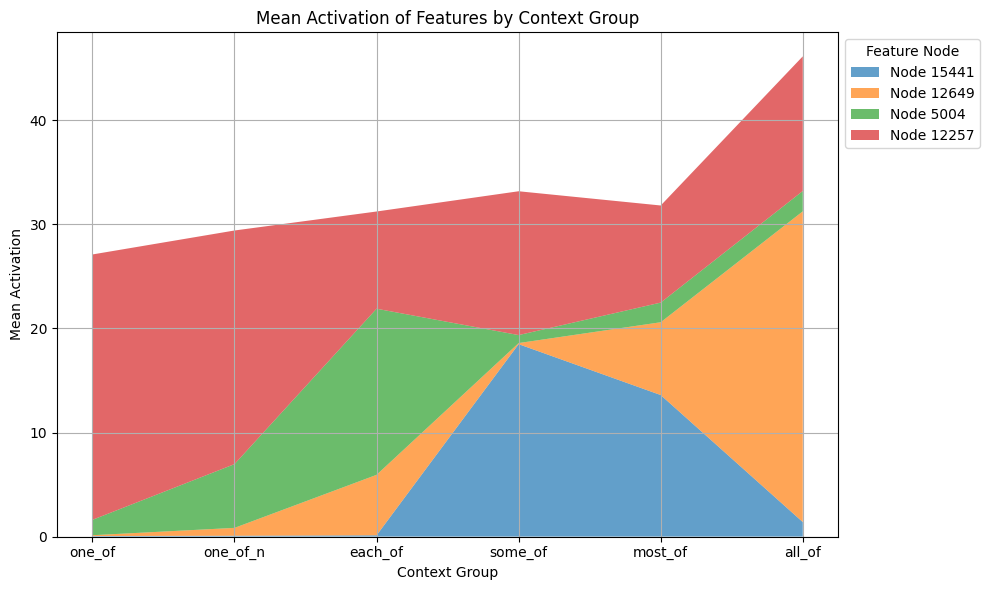

In [67]:
plot_mean_activation_area_chart(
    pca_df, reprocessed_results.all_graph_feature_acts, fs_splitting_nodes
)

In [64]:
def plot_mean_activation_stacked_bar_chart(
    pca_df, all_graph_feature_acts, fs_splitting_nodes, context_col="context"
):
    # remove any | character from context
    pca_df[context_col] = pca_df[context_col].str.replace("|", "")
    # Define context groups
    groups = {
        "one_of": pca_df[context_col].str.contains(r"\b(one of)\b")
        & ~pca_df[context_col].str.contains(
            r"\b(two|three|four|five|six|seven|eight|nine|ten|first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|these|least|any|each)\b"
        ),
        "one_of_n": pca_df[context_col].str.contains(r"\bone of\b")
        & pca_df[context_col].str.contains(
            r"\b(two|three|four|five|six|seven|eight|nine|ten|first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|these|least|any|each)\b"
        ),
        "each_of": pca_df[context_col].str.contains(
            r"\b(both of|each of|neither of|every one of|either of)\b"
        ),
        "some_of": pca_df[context_col].str.contains(r"\bsome of\b"),
        "most_of": pca_df[context_col].str.contains(
            r"\b(many of|most of|almost all of|nearly all of)\b"
        ),
        "all_of": pca_df[context_col].str.contains(r"\ball of\b")
        & ~pca_df[context_col].str.contains(r"\b(almost|nearly)\b"),
    }

    # Calculate mean activations for each group using all_graph_feature_acts
    mean_activations = {
        group: all_graph_feature_acts[mask].mean(axis=0)
        for group, mask in groups.items()
    }

    # Prepare data for stacked bar plot
    group_names = list(mean_activations.keys())
    stacked_data = np.array([mean_activations[group] for group in group_names])

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    bottom = np.zeros(len(group_names))
    for i, feature_data in enumerate(stacked_data.T):
        plt.bar(
            group_names,
            feature_data,
            bottom=bottom,
            label=f"Node {fs_splitting_nodes[i]}",
            alpha=0.7,
        )
        bottom += feature_data

    plt.title("Mean Activation of Features by Context Group")
    plt.xlabel("Context Group")
    plt.ylabel("Mean Activation")
    plt.legend(title="Feature Node", loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
# plot_mean_activation_stacked_bar_chart(pca_df, reprocessed_results.all_graph_feature_acts, fs_splitting_nodes)

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/1182491210.py:8: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/1182491210.py:9: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/1182491210.py:10: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/1182491210.py:12: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/1182491210.py:13: UserWarning:

This pattern is interpreted as a 

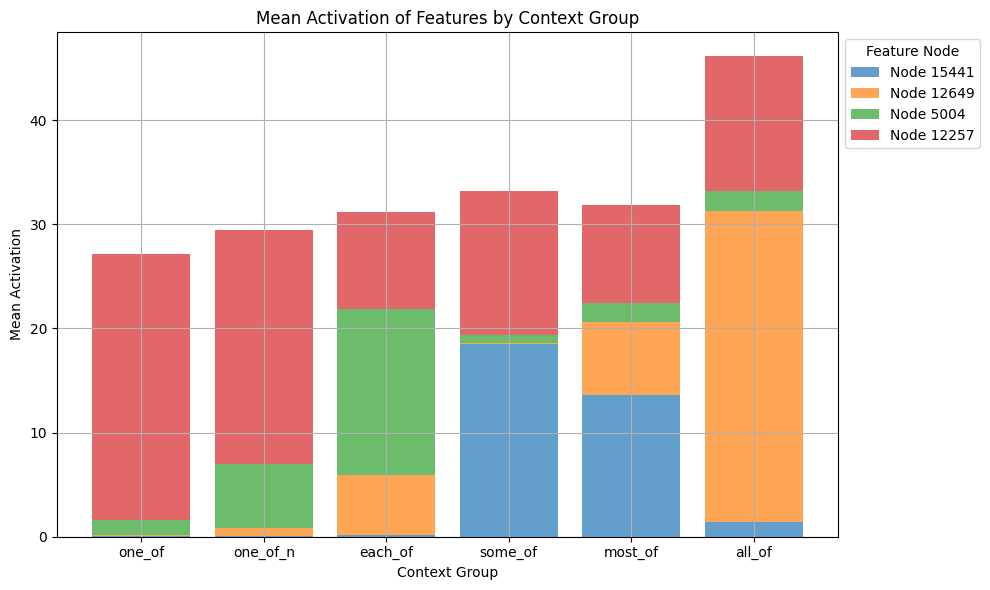

In [65]:
plot_mean_activation_stacked_bar_chart(
    pca_df, reprocessed_results.all_graph_feature_acts, fs_splitting_nodes
)

In [62]:
def plot_pca_colored_by_context_group(pca_df, context_col="context"):
    # remove any | character from context
    pca_df[context_col] = pca_df[context_col].str.replace("|", "")
    # Define context groups
    groups = {
        "one_of": pca_df[context_col].str.contains(r"\b(one of)\b")
        & ~pca_df[context_col].str.contains(
            r"\b(two|three|four|five|six|seven|eight|nine|ten|first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|these|least|any|each)\b"
        ),
        "one_of_n": pca_df[context_col].str.contains(r"\bone of\b")
        & pca_df[context_col].str.contains(
            r"\b(two|three|four|five|six|seven|eight|nine|ten|first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|these|least|any|each)\b"
        ),
        "each_of": pca_df[context_col].str.contains(
            r"\b(both of|each of|neither of|every one of|either of)\b"
        ),
        "some_of": pca_df[context_col].str.contains(r"\bsome of\b"),
        "most_of": pca_df[context_col].str.contains(
            r"\b(many of|most of|almost all of|nearly all of)\b"
        ),
        "all_of": pca_df[context_col].str.contains(r"\ball of\b")
        & ~pca_df[context_col].str.contains(r"\b(almost|nearly)\b"),
    }

    # Assign a color to each group
    colors = {
        "one_of": "red",
        "one_of_n": "blue",
        "each_of": "green",
        "some_of": "purple",
        "most_of": "orange",
        "all_of": "brown",
    }

    # Plot PCA with colors based on context groups
    plt.figure(figsize=(10, 6))
    for group, mask in groups.items():
        plt.scatter(
            pca_df.loc[mask, "PC2"],
            pca_df.loc[mask, "PC3"],
            label=group,
            color=colors[group],
            alpha=0.7,
        )

    plt.title("PCA Colored by Context Group")
    plt.xlabel("PC2")
    plt.ylabel("PC3")
    plt.legend(title="Context Group")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
# plot_pca_colored_by_context_group(pca_df)

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/2690801410.py:9: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/2690801410.py:10: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/2690801410.py:11: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/2690801410.py:13: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_19447/2690801410.py:14: UserWarning:

This pattern is interpreted as a

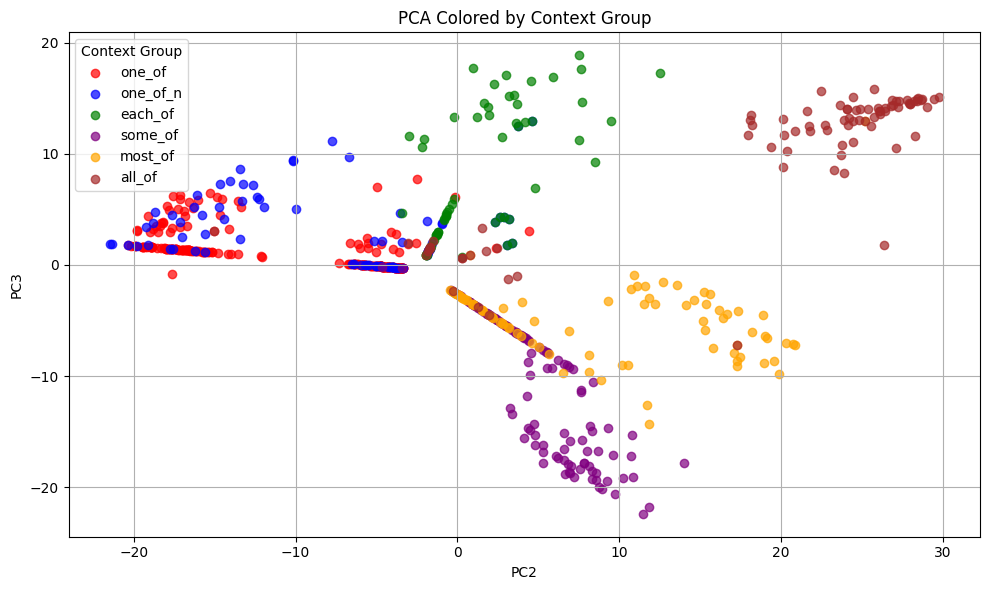

In [63]:
plot_pca_colored_by_context_group(pca_df)

In [49]:
def plot_pca_colored_by_feature_combination(
    pca_df, all_graph_feature_acts, fs_splitting_nodes, threshold=0
):
    # Define feature combinations and their corresponding colors
    feature_combinations = {
        (12257,): "red",
        (12257, 5004): "blue",
        (12257, 5004, 12649): "green",
        (12257, 15441): "purple",
        (12257, 15441, 12649): "orange",
        (12257, 12649): "brown",
    }

    # Create a mask for each combination
    masks = {}
    for combination, color in feature_combinations.items():
        # Check if the exact combination is active
        exact_mask = np.all(
            all_graph_feature_acts[
                :, [fs_splitting_nodes.index(f) for f in combination]
            ]
            > threshold,
            axis=1,
        )
        # Ensure no additional features are active
        no_extra_features = np.sum(all_graph_feature_acts > threshold, axis=1) == len(
            combination
        )
        masks[combination] = exact_mask & no_extra_features

    # Plot PCA with colors based on feature combinations
    plt.figure(figsize=(10, 6))
    for combination, mask in masks.items():
        plt.scatter(
            pca_df.loc[mask, "PC2"],
            pca_df.loc[mask, "PC3"],
            label=f"Features {combination}",
            color=feature_combinations[combination],
            alpha=0.7,
        )

    plt.title("PCA Colored by Feature Combination")
    plt.xlabel("PC2")
    plt.ylabel("PC3")
    plt.legend(title="Feature Combination")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
# plot_pca_colored_by_feature_combination(pca_df, reprocessed_results.all_graph_feature_acts, fs_splitting_nodes, threshold=10)

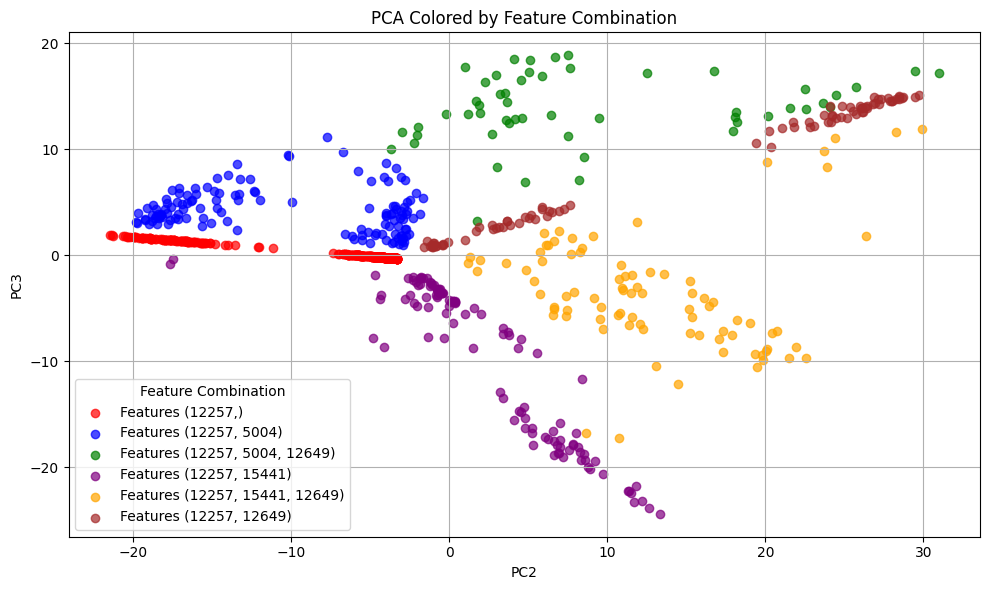

In [51]:
plot_pca_colored_by_feature_combination(
    pca_df,
    reprocessed_results.all_graph_feature_acts,
    fs_splitting_nodes,
    threshold=1.5,
)